In [1]:
from netCDF4 import Dataset
import numpy as np
import datetime as dt
import os

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

from tqdm.notebook import tqdm

from netCDFfunc import get_data_A

def get_data(year, month, day, variable_name, is_mask=False) -> np.ndarray:

    date = dt.date(year,month,day).strftime('%Y%m%d')
    
    is_value = False
    
    if variable_name in ['anom', 'err', 'ice', 'sst'] :
        is_value = True
    
    if year < 2016 : 
        D = Dataset(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/oisst-avhrr-v02r01.{date}.nc', 'r', format='NETCDF4')
        variables = ['anom', 'err', 'ice', 'lat', 'lon', 'sst', 'time', 'zlev']

    else :
        if os.path.exists(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'):
            D = Dataset(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc', 'r', format='NETCDF4')
        else :
            D = Dataset(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.1-fv02.1.nc', 'r', format='NETCDF4')
        
        if variable_name == 'err' : variable_name = 'analysis_error'
        elif variable_name == 'sst' : variable_name = 'analysed_sst'
        elif variable_name == 'ice' : variable_name = 'sea_ice_fraction'
        
        variables = ['lat', 'lon', 'time', 'lat_bnds', 'lon_bnds', 'analysed_sst', 'analysis_error', 'mask', 'sea_ice_fraction']
    
    var = D[variable_name]
    masked_array = var[:]
    
    if is_value == True :
        if year < 2016 : 
            data = masked_array.data[0][0]
            mask = masked_array.mask[0][0]
        else : 
            data = np.roll(masked_array.data[0], 720)
            mask = np.roll(masked_array.mask[0], 720)
    else :
        if year < 2016 :
            data = masked_array.data
            mask = masked_array.mask
        else : 
            data = np.roll(masked_array.data, 720)
            mask = np.roll(masked_array.mask, 720)

    D.close()
    
    if is_mask == False : return data
    else : return mask

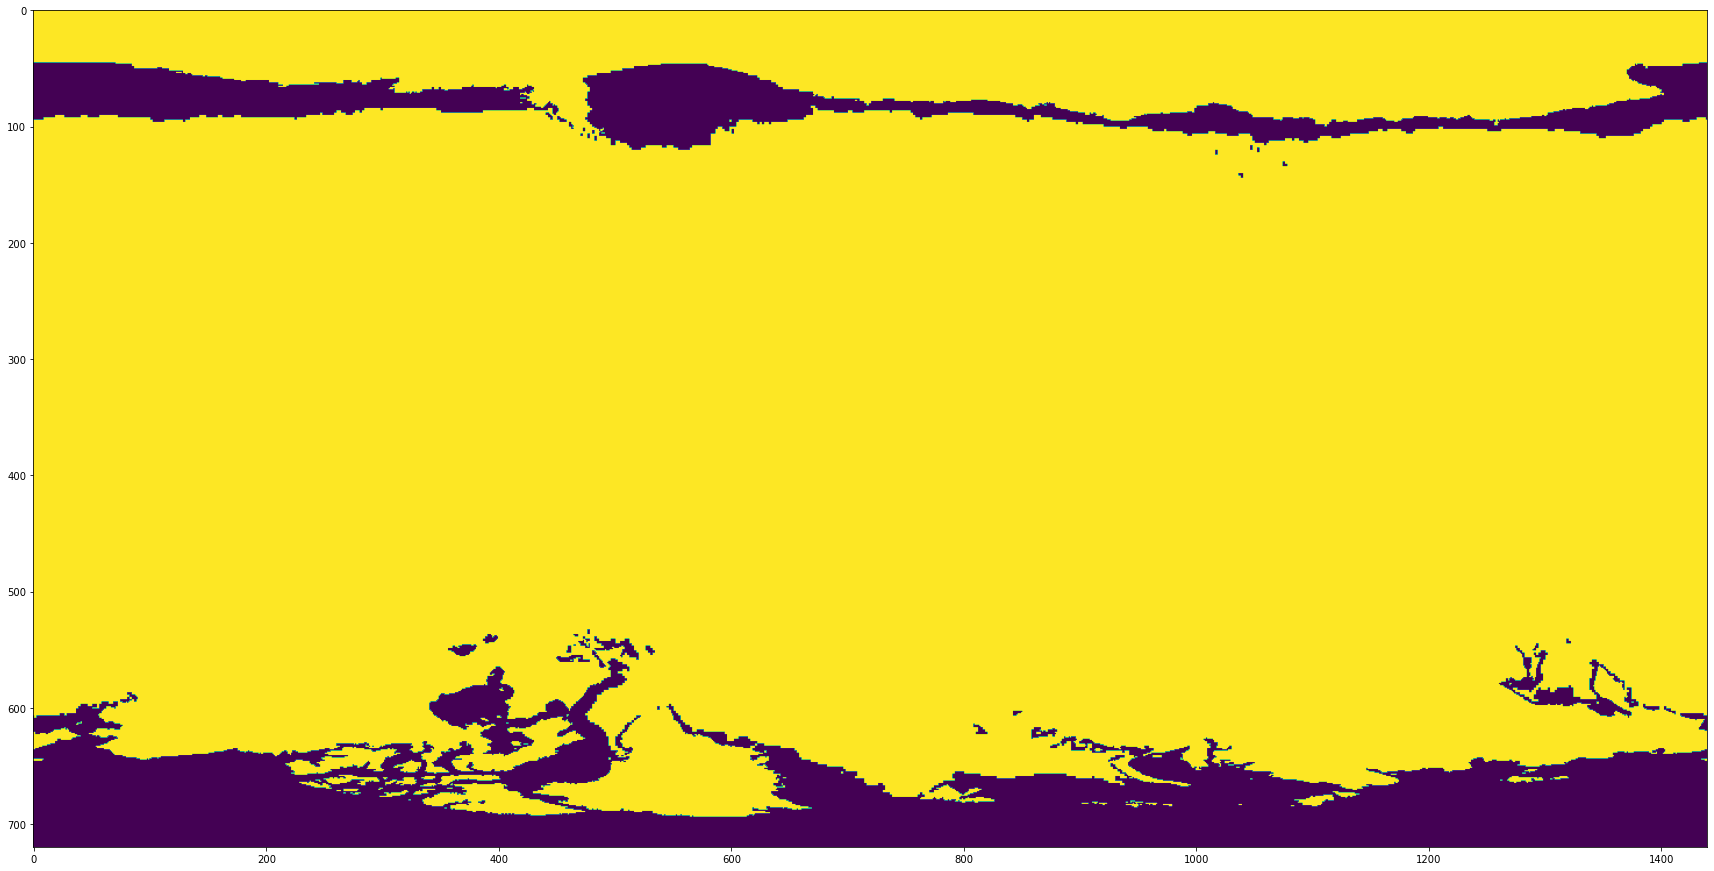

In [63]:
ice_2020 = get_data(2020,5,6,'ice',is_mask=True)
fig = plt.figure(figsize=(30,20))
plt.imshow(ice_2020)
plt.show()

# mask 변화

In [2]:
months = range(1,13)

result = []
days = [31,28,31,30,31,30,31,31,30,31,30,31]
for year in tqdm(range(1981,2022)):
    for month, day_len in zip(months, days):
        for date in range(1,day_len+1):
            if year == 1981 and month in [1,2,3,4,5,6,7,8]:
                continue
            if year == 2021 and month == 1 and date == 16 :
                continue
            result.append(get_data_A(year,month,date,'err', is_mask=True))

  0%|          | 0/41 [00:00<?, ?it/s]

In [3]:
result = np.array(result)
result = result.astype('uint8')
result = result * 100

In [4]:
length = result.shape[0]

out = cv2.VideoWriter('../data/output.mov', cv2.VideoWriter_fourcc(*'mp4v'), 360, (1440, 720), False)

for i in range(length):
    data = result[i]
    out.write(data)

out.release()